In [23]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
import random
from sklearn.preprocessing import LabelEncoder
import os

In [24]:

pos_df = pd.read_csv('positive10k.txt', sep='\t', header=None) 
neg_df = pd.read_csv('negative10k.txt', sep='\t', header=None)
cmt_msg_df = pd.read_csv('commit-messages.txt', sep='\t', header=None) 
question_df = pd.read_csv('questions.txt', sep='\t', header=None) 

pos_df.shape, neg_df.shape, cmt_msg_df.shape, question_df.shape

((9935, 1), (9719, 1), (14195, 1), (5742, 1))

In [25]:
pos_df[1]='positive'
neg_df[1]='negative'
cmt_msg_df[1]='enhancement'
question_df[1]='question'

In [26]:
df = pd.DataFrame(pos_df)
df = df.append(neg_df)
df = df.append(cmt_msg_df[:10000])
df = df.append(question_df)
df.shape

(35396, 2)

In [27]:
df[1].value_counts(), df[1].value_counts().sum(),df[1].value_counts()["enhancement"]

(enhancement    10000
 positive        9935
 negative        9719
 question        5742
 Name: 1, dtype: int64,
 35396,
 10000)

In [28]:
total_rows =  df[1].value_counts().sum()
weight_for_enhancement = (1 / df[1].value_counts()["enhancement"])*(total_rows)/4.0
weight_for_positive = (1 / df[1].value_counts()["positive"])*(total_rows)/4.0
weight_for_negative = (1 / df[1].value_counts()["negative"])*(total_rows)/4.0
weight_for_question = (1 / df[1].value_counts()["question"])*(total_rows)/4.0
weight_for_enhancement, weight_for_positive,weight_for_negative, weight_for_question

(0.8849, 0.8906894816305989, 0.9104846177590287, 1.5411006617903171)

In [29]:
df = df.sample(frac = 1, random_state = 42)
df

,0,1
3089,They don't let you make enough coins to get th...,negative
1998,where does the paraguay river start and end,question
557,who plays izabella in transformers the last kn...,question
1805,Upgrade CI to Docker 20.10.6,enhancement
5258,who holds the major league baseball career hit...,question
...,...,...
6915,Only two free puzzles out of 6 .. bs,negative
6265,Excellent Apps Very nice easy to use....... T...,positive
1349,0 stars Would give it 5 stars if you would fix...,negative
860,Good game I can play it but i wish it didn't h...,positive


<AxesSubplot:>

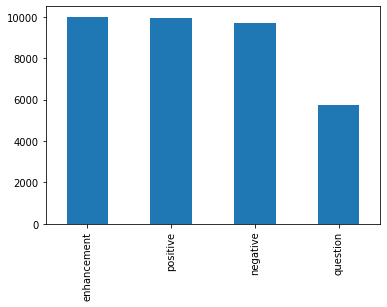

In [30]:
df[1].value_counts().plot(kind='bar')


In [31]:
from sklearn.model_selection import train_test_split
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(df[0].to_numpy(),
                                                                            df[1].to_numpy(),
                                                                            test_size=0.2, # dedicate 10% of samples to validation set
                                                                            random_state=42)
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)


(28316, 28316, 7080, 7080)

In [32]:
max_vocab_length = 10000
avg_sentence_length = int(np.mean([len(s.split()) for s in train_sentences]))
avg_sentence_length

14

In [33]:
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                     standardize="lower_and_strip_punctuation", # how to process text
                                    split="whitespace", # how to split tokens
                                    output_sequence_length=avg_sentence_length)
text_vectorizer.adapt(train_sentences)

In [34]:
# integer encode
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)
y_test = label_encoder.transform(val_labels)
y_train[0],y_test[0] , label_encoder.classes_

(0,
 3,
 array(['enhancement', 'negative', 'positive', 'question'], dtype=object))

In [35]:
class_weight = {0: weight_for_enhancement, 1: weight_for_negative, 2: weight_for_positive, 3: weight_for_question}

In [36]:
train_sentences[0], val_sentences[0], y_train[0], y_test[0]

('This commit introduces support for an empty `@DefaultValue` which',
 'who sings i just want to use your love tonight ',
 0,
 3)

In [37]:
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = layers.Embedding(max_vocab_length, 128)(x) # create an embedding of the numerized numbers
#x = layers.GRU(128)(x) # create a GRU layer with 128 units
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.9, recurrent_dropout=0.9))(x) # stacking RNN layers requires return_sequences=True
x = layers.Bidirectional(layers.LSTM(32, dropout=0.7, recurrent_dropout=0.9))(x) # bidirectional goes both ways so has double the parameters of a regular LSTM layer
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(4, activation="softmax")(x) # create the output layer, want binary outputs so use sigmoid activation
model = tf.keras.Model(inputs, outputs, name="model_1_dense") # construct the model

model.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [38]:
with tf.device('/cpu:0'):
    model_history = model.fit(train_sentences, # input sentences can be a list of strings due to text preprocessing layer built-in model
                                y_train,
                                epochs=5,
                                verbose=1,
                                validation_data=(val_sentences, y_test),
                                class_weight=class_weight)

Epoch 1/5
885/885 [==============================] - 121s 111ms/step - loss: 0.5361 - accuracy: 0.7617 - val_loss: 0.2913 - val_accuracy: 0.8873
Epoch 2/5
885/885 [==============================] - 99s 112ms/step - loss: 0.2719 - accuracy: 0.8899 - val_loss: 0.2247 - val_accuracy: 0.9161
Epoch 3/5
885/885 [==============================] - 96s 109ms/step - loss: 0.2114 - accuracy: 0.9147 - val_loss: 0.2119 - val_accuracy: 0.9230
Epoch 4/5
885/885 [==============================] - 98s 111ms/step - loss: 0.1877 - accuracy: 0.9266 - val_loss: 0.2078 - val_accuracy: 0.9242
Epoch 5/5
885/885 [==============================] - 95s 108ms/step - loss: 0.1679 - accuracy: 0.9358 - val_loss: 0.2082 - val_accuracy: 0.9267


In [43]:
prediction=model.predict(["Where are the helm charts"])
label_encoder.inverse_transform([np.argmax(prediction)])

array(['question'], dtype=object)